# rule based feature 추출

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter
import os

%matplotlib inline

wd = Path.cwd()
data_path = wd.parent / 'data'

## Anode

In [3]:
Anode_Normal = sorted([x for x in Path(os.path.join(data_path, "230507/Anode/Normal")).glob("*.csv")])
Anode_Normal = sorted(Anode_Normal)

Anode_Abnormal = sorted([x for x in Path(os.path.join(data_path, "230507/Anode/Abnormal")).glob("*.csv")])
Anode_Abnormal = sorted(Anode_Abnormal)
len(Anode_Normal), len(Anode_Abnormal)

(35, 18)

In [4]:
# data = pd.read_csv(os.path.join(data_path, "230507/Anode/Normal/20230412_110032_0__03_Total.csv"))
# len(data)

# data2 = pd.read_csv(os.path.join(data_path, "230507/Anode/Normal/31.csv"))
# len(data2)

In [5]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

### Dataset별 bead detection 후 time series concat

In [7]:
def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

def bp_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-precision score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-precision
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[1] > m[1]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

## Train Test split
### Train -> 35개 정상 dataset 중 80%인 28개
### Test -> 18개 비정상 dataset + 정상 7개 dataset = 25개 dataset

In [8]:
len(Anode_Normal)

35

In [54]:
data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Test = pd.concat([Anode_Test, bead_i])


warning index: 40140
error index: 40239
warning index: 40690
error index: 40789
warning index: 41239
error index: 41338
warning index: 41788
error index: 41887
warning index: 42337
error index: 42436
warning index: 42886
error index: 42985
warning index: 43436
error index: 43535
warning index: 43986
error index: 44085
warning index: 44535
error index: 44634
warning index: 45085
error index: 45184
warning index: 45634
error index: 45733
warning index: 46184
error index: 46283
warning index: 46733
error index: 46832
warning index: 47282
error index: 47381
warning index: 47832
error index: 47931
warning index: 48381
error index: 48480
warning index: 48930
error index: 49029
warning index: 49479
error index: 49578
warning index: 50028
error index: 50127
warning index: 50577
error index: 50676
warning index: 51127
error index: 51226
warning index: 51676
error index: 51775
warning index: 52226
error index: 52325
warning index: 52775
error index: 52874
warning index: 53325
error index: 53424


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 50276
error index: 50375
warning index: 50826
error index: 50925
warning index: 51375
error index: 51474
warning index: 51924
error index: 52023
warning index: 52473
error index: 52572
warning index: 53022
error index: 53121
warning index: 53572
error index: 53671
warning index: 54122
error index: 54221
warning index: 54671
error index: 54770
warning index: 55221
error index: 55320
warning index: 55770
error index: 55869
warning index: 56320
error index: 56419
warning index: 56869
error index: 56968
warning index: 57418
error index: 57517
warning index: 57968
error index: 58067
warning index: 58517
error index: 58616
warning index: 59066
error index: 59165
warning index: 59615
error index: 59714
warning index: 60164
error index: 60263
warning index: 60713
error index: 60812
warning index: 61263
error index: 61362
warning index: 61812
error index: 61911
warning index: 62362
error index: 62461
warning index: 62911
error index: 63010
warning index: 63461
error index: 63560


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 41027
error index: 41126
warning index: 41577
error index: 41676
warning index: 42126
error index: 42225
warning index: 42675
error index: 42774
warning index: 43224
error index: 43323
warning index: 43773
error index: 43872
warning index: 44323
error index: 44422
warning index: 44873
error index: 44972
warning index: 45422
error index: 45521
warning index: 45972
error index: 46071
warning index: 46521
error index: 46620
warning index: 47071
error index: 47170
warning index: 47620
error index: 47719
warning index: 48169
error index: 48268
warning index: 48719
error index: 48818
warning index: 49268
error index: 49367
warning index: 49817
error index: 49916
warning index: 50366
error index: 50465
warning index: 50915
error index: 51014
warning index: 51466
error index: 51563
warning index: 52014
error index: 52113
warning index: 52563
error index: 52662
warning index: 53113
error index: 53212
warning index: 53662
error index: 53761
warning index: 54212
error index: 54311


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 47108
warning index: 47109
error index: 47207
warning index: 47658
error index: 47757
warning index: 48207
warning index: 48208
error index: 48306
warning index: 48756
error index: 48855
warning index: 49305
warning index: 49306
error index: 49404
warning index: 49854
warning index: 49855
error index: 49953
warning index: 50404
warning index: 50405
error index: 50503
warning index: 50954
warning index: 50955
error index: 51053
warning index: 51503
error index: 51602
warning index: 52053
warning index: 52054
error index: 52152
warning index: 52602
warning index: 52603
error index: 52701
warning index: 53152
warning index: 53153
error index: 53251
warning index: 53701
error index: 53800
warning index: 54250
warning index: 54251
error index: 54349
warning index: 54800
error index: 54899
warning index: 55349
warning index: 55350
error index: 55448
warning index: 55898
warning index: 55899
error index: 55997
warning index: 56447
warning index: 56448
error index: 56546
warning

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 46925
warning index: 46926
error index: 47024
warning index: 47475
warning index: 47476
error index: 47574
warning index: 48024
error index: 48123
warning index: 48573
error index: 48672
warning index: 49122
error index: 49221
warning index: 49671
error index: 49770
warning index: 50221
error index: 50320
warning index: 50771
error index: 50870
warning index: 51320
warning index: 51321
error index: 51419
warning index: 51870
warning index: 51871
error index: 51969
warning index: 52419
error index: 52518
warning index: 52969
error index: 53068
warning index: 53518
error index: 53617
warning index: 54067
warning index: 54068
error index: 54166
warning index: 54617
warning index: 54618
error index: 54716
warning index: 55166
error index: 55265
warning index: 55715
error index: 55814
warning index: 56264
error index: 56363
warning index: 56812
error index: 56912
warning index: 57362
error index: 57461
warning index: 57912
error index: 58011
warning index: 58461
error index: 

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 44185
error index: 44284
warning index: 44735
error index: 44834
warning index: 45284
error index: 45383
warning index: 45833
error index: 45932
warning index: 46382
error index: 46481
warning index: 46931
error index: 47030
warning index: 47481
error index: 47580
warning index: 48031
error index: 48130
warning index: 48580
error index: 48679
warning index: 49130
error index: 49229
warning index: 49679
error index: 49778
warning index: 50229
error index: 50328
warning index: 50778
error index: 50877
warning index: 51327
error index: 51426
warning index: 51877
error index: 51976
warning index: 52426
error index: 52525
warning index: 52975
error index: 53074
warning index: 53524
error index: 53623
warning index: 54073
error index: 54172
warning index: 54622
error index: 54721
warning index: 55172
error index: 55271
warning index: 55721
error index: 55820
warning index: 56271
error index: 56370
warning index: 56820
error index: 56919
warning index: 57370
error index: 57469


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 50916
error index: 51014
warning index: 51466
error index: 51564
warning index: 52015
error index: 52113
warning index: 52564
error index: 52662
warning index: 53113
error index: 53211
warning index: 53661
warning index: 53662
error index: 53760
warning index: 54212
error index: 54310
warning index: 54762
error index: 54860
warning index: 55311
error index: 55409
warning index: 55860
warning index: 55861
error index: 55959
warning index: 56409
warning index: 56410
error index: 56508
warning index: 56959
warning index: 56960
error index: 57058
warning index: 57508
warning index: 57509
error index: 57607
warning index: 58057
warning index: 58058
error index: 58156
warning index: 58608
error index: 58706
warning index: 59156
warning index: 59157
error index: 59255
warning index: 59706
error index: 59804
warning index: 60254
warning index: 60255
error index: 60353
warning index: 60804
error index: 60902
warning index: 61353
error index: 61451
warning index: 61903
error index

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 46607
error index: 46706
warning index: 47157
error index: 47256
warning index: 47706
error index: 47804
warning index: 48255
error index: 48353
warning index: 48804
error index: 48902
warning index: 49353
error index: 49451
warning index: 49903
error index: 50001
warning index: 50453
error index: 50551
error index: 50552
warning index: 51002
error index: 51100
warning index: 51552
error index: 51650
error index: 51651
warning index: 52101
error index: 52199
warning index: 52651
error index: 52749
warning index: 53200
error index: 53298
warning index: 53749
error index: 53847
error index: 53848
warning index: 54299
error index: 54397
warning index: 54848
error index: 54946
warning index: 55397
error index: 55495
warning index: 55946
error index: 56044
warning index: 56495
error index: 56593
warning index: 57044
error index: 57142
warning index: 57594
error index: 57692
warning index: 58143
error index: 58241
warning index: 58693
error index: 58791
error index: 58792
warn

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 44186
error index: 44285
warning index: 44736
error index: 44835
warning index: 45285
error index: 45384
warning index: 45834
error index: 45933
warning index: 46383
error index: 46482
warning index: 46932
error index: 47031
warning index: 47482
error index: 47581
warning index: 48032
error index: 48131
warning index: 48581
error index: 48680
warning index: 49131
error index: 49230
warning index: 49680
error index: 49779
warning index: 50230
error index: 50329
warning index: 50779
error index: 50878
warning index: 51328
error index: 51427
warning index: 51878
error index: 51977
warning index: 52427
error index: 52526
warning index: 52976
error index: 53075
warning index: 53525
error index: 53624
warning index: 54074
error index: 54173
warning index: 54623
error index: 54722
warning index: 55173
error index: 55272
warning index: 55722
error index: 55821
warning index: 56272
error index: 56371
warning index: 56821
error index: 56920
warning index: 57371
error index: 57470


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 49734
error index: 49832
warning index: 50284
error index: 50382
warning index: 50833
error index: 50931
warning index: 51382
error index: 51480
warning index: 51931
error index: 52029
warning index: 52480
error index: 52578
warning index: 53030
error index: 53128
warning index: 53580
error index: 53678
warning index: 54129
error index: 54227
warning index: 54679
error index: 54777
warning index: 55228
error index: 55326
warning index: 55778
error index: 55876
warning index: 56327
error index: 56425
warning index: 56876
error index: 56974
warning index: 57426
error index: 57524
warning index: 57975
error index: 58073
warning index: 58524
error index: 58622
warning index: 59073
error index: 59171
warning index: 59622
error index: 59720
warning index: 60171
error index: 60269
warning index: 60721
error index: 60819
warning index: 61270
error index: 61368
warning index: 61819
error index: 61918
warning index: 62368
error index: 62467
warning index: 62918
error index: 63017


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 40641
error index: 40740
warning index: 41191
error index: 41290
warning index: 41740
error index: 41839
warning index: 42289
error index: 42388
warning index: 42838
error index: 42937
warning index: 43387
error index: 43486
warning index: 43937
error index: 44036
warning index: 44487
error index: 44586
warning index: 45036
error index: 45135
warning index: 45586
error index: 45685
warning index: 46135
error index: 46234
warning index: 46685
error index: 46784
warning index: 47234
error index: 47333
warning index: 47783
error index: 47882
warning index: 48333
warning index: 48882
error index: 48981
warning index: 49431
error index: 49530
warning index: 49980
error index: 50079
warning index: 50529
error index: 50628
warning index: 51078
error index: 51177
warning index: 51628
error index: 51727
warning index: 52177
error index: 52276
warning index: 52727
error index: 52826
warning index: 53276
error index: 53375
warning index: 53826
error index: 53925
warning index: 5437

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 40906
error index: 41005
warning index: 41456
error index: 41555
warning index: 42005
error index: 42104
warning index: 42554
error index: 42653
warning index: 43103
error index: 43202
warning index: 43652
error index: 43751
warning index: 44202
error index: 44301
warning index: 44752
error index: 44851
warning index: 45301
error index: 45400
warning index: 45851
error index: 45950
warning index: 46400
error index: 46499
warning index: 46950
error index: 47049
warning index: 47499
error index: 47598
warning index: 48048
error index: 48147
warning index: 48598
error index: 48697
warning index: 49147
error index: 49246
warning index: 49696
error index: 49795
warning index: 50245
error index: 50344
warning index: 50794
error index: 50893
warning index: 51343
error index: 51442
warning index: 51893
error index: 51992
warning index: 52442
error index: 52541
warning index: 52992
error index: 53091
warning index: 53541
error index: 53640
warning index: 54091
error index: 54190


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 45939
error index: 46037
warning index: 46489
warning index: 47038
error index: 47136
error index: 47137
warning index: 47587
error index: 47685
error index: 47686
warning index: 48136
error index: 48234
warning index: 48684
warning index: 48685
error index: 48783
error index: 49333
error index: 49883
warning index: 50333
warning index: 50334
error index: 50432
error index: 50433
warning index: 50884
error index: 50982
error index: 50983
warning index: 51432
warning index: 51433
error index: 51531
warning index: 51982
warning index: 51983
error index: 52081
error index: 52630
warning index: 53081
error index: 53179
warning index: 53631
error index: 53729
warning index: 54179
warning index: 54180
error index: 54278
warning index: 54729
error index: 54827
warning index: 55277
warning index: 55278
error index: 55376
warning index: 55826
warning index: 55827
error index: 55925
warning index: 56375
warning index: 56376
error index: 56474
error index: 56475
warning index: 5692

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 45347
error index: 45446
warning index: 45897
error index: 45996
warning index: 46446
error index: 46545
warning index: 46995
error index: 47094
warning index: 47544
error index: 47643
warning index: 48093
error index: 48192
warning index: 48643
error index: 48742
warning index: 49193
error index: 49292
warning index: 49742
error index: 49841
warning index: 50292
error index: 50390
warning index: 50841
error index: 50939
warning index: 51391
error index: 51489
warning index: 51940
error index: 52038
warning index: 52489
error index: 52587
warning index: 53039
error index: 53137
warning index: 53588
error index: 53686
warning index: 54137
error index: 54235
warning index: 54686
error index: 54784
warning index: 55235
error index: 55333
warning index: 55784
error index: 55882
warning index: 56334
error index: 56432
warning index: 56883
error index: 56981
warning index: 57433
error index: 57531
warning index: 57982
error index: 58080
warning index: 58532
error index: 58630


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 71554
error index: 71652
warning index: 72103
warning index: 72104
error index: 72202
warning index: 72652
warning index: 72653
error index: 72751
warning index: 73201
warning index: 73202
error index: 73300
warning index: 73750
error index: 73849
warning index: 74299
warning index: 74300
error index: 74398
warning index: 74849
warning index: 74850
error index: 74948
warning index: 75399
error index: 75498
warning index: 75948
error index: 76047
warning index: 76498
warning index: 76499
error index: 76597
warning index: 77047
error index: 77146
warning index: 77597
error index: 77696
warning index: 78146
error index: 78245
warning index: 78695
warning index: 78696
error index: 78794
warning index: 79245
warning index: 79246
error index: 79344
warning index: 79794
error index: 79893
warning index: 80343
error index: 80442
warning index: 80892
warning index: 80893
error index: 80991
warning index: 81441
error index: 81540
warning index: 81990
error index: 82089
warning ind

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 44914
error index: 45013
warning index: 45464
error index: 45563
warning index: 46013
error index: 46112
warning index: 46562
warning index: 47111
error index: 47210
warning index: 47660
error index: 47759
warning index: 48210
error index: 48309
warning index: 48760
error index: 48859
warning index: 49309
error index: 49408
warning index: 49859
error index: 49958
warning index: 50408
error index: 50507
warning index: 50958
error index: 51057
warning index: 51507
error index: 51606
warning index: 52056
error index: 52155
warning index: 52606
error index: 52705
warning index: 53155
error index: 53254
warning index: 53704
error index: 53803
warning index: 54253
error index: 54352
warning index: 54802
error index: 54901
warning index: 55351
error index: 55450
warning index: 55901
error index: 56000
warning index: 56450
error index: 56549
warning index: 57000
error index: 57099
warning index: 57549
error index: 57648
warning index: 58099
error index: 58198
warning index: 5864

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 37222
error index: 37320
warning index: 37771
warning index: 37772
error index: 37870
warning index: 38320
warning index: 38321
error index: 38419
warning index: 38869
warning index: 38870
error index: 38968
warning index: 39418
error index: 39517
warning index: 39967
warning index: 39968
error index: 40066
warning index: 40517
warning index: 40518
error index: 40616
warning index: 41067
warning index: 41068
error index: 41166
warning index: 41616
error index: 41715
warning index: 42166
warning index: 42167
error index: 42265
warning index: 42715
warning index: 42716
error index: 42814
warning index: 43265
warning index: 43266
error index: 43364
warning index: 43814
warning index: 43815
error index: 43913
warning index: 44363
warning index: 44364
error index: 44462
warning index: 44913
error index: 45012
warning index: 45462
warning index: 45463
error index: 45561
warning index: 46011
error index: 46110
warning index: 46560
warning index: 46561
error index: 46659
warning

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 40508
error index: 40607
warning index: 41058
error index: 41157
warning index: 41607
error index: 41706
warning index: 42156
error index: 42255
warning index: 42705
error index: 42804
warning index: 43254
error index: 43353
warning index: 43804
error index: 43903
warning index: 44354
error index: 44453
warning index: 44903
error index: 45002
warning index: 45453
error index: 45552
warning index: 46002
error index: 46101
warning index: 46552
error index: 46651
warning index: 47101
error index: 47200
warning index: 47650
error index: 47749
warning index: 48200
error index: 48299
warning index: 48749
error index: 48848
warning index: 49298
error index: 49397
warning index: 49847
error index: 49946
warning index: 50396
error index: 50495
warning index: 50945
error index: 51044
warning index: 51495
error index: 51594
warning index: 52044
error index: 52143
warning index: 52594
error index: 52693
warning index: 53143
error index: 53242
warning index: 53693
error index: 53792


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 45317
error index: 45416
warning index: 45867
error index: 45966
warning index: 46416
error index: 46515
warning index: 46965
error index: 47064
warning index: 47514
error index: 47613
warning index: 48063
error index: 48162
warning index: 48613
error index: 48712
warning index: 49163
error index: 49262
warning index: 49712
error index: 49811
warning index: 50262
error index: 50361
warning index: 50811
error index: 50910
warning index: 51361
error index: 51460
warning index: 51910
error index: 52009
warning index: 52459
error index: 52558
warning index: 53009
error index: 53108
warning index: 53558
error index: 53657
warning index: 54107
error index: 54206
warning index: 54656
error index: 54755
warning index: 55205
error index: 55304
warning index: 55754
error index: 55853
warning index: 56304
error index: 56403
warning index: 56853
error index: 56952
warning index: 57403
error index: 57502
warning index: 57952
error index: 58051
warning index: 58502
error index: 58601


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 55019
warning index: 55020
error index: 55118
warning index: 55569
error index: 55668
warning index: 56118
error index: 56217
warning index: 56667
error index: 56766
warning index: 57216
error index: 57315
warning index: 57765
error index: 57864
warning index: 58315
error index: 58414
warning index: 58865
error index: 58964
warning index: 59414
error index: 59513
warning index: 59964
error index: 60063
warning index: 60513
error index: 60612
warning index: 61063
error index: 61162
warning index: 61612
error index: 61711
warning index: 62161
error index: 62260
warning index: 62711
error index: 62810
warning index: 63260
error index: 63359
warning index: 63809
error index: 63908
warning index: 64358
error index: 64457
warning index: 64907
error index: 65005
warning index: 65456
error index: 65554
warning index: 66006
error index: 66104
warning index: 66555
error index: 66653
warning index: 67105
error index: 67203
warning index: 67654
error index: 67752
warning index: 6820

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 53078
error index: 53177
warning index: 53628
error index: 53727
warning index: 54177
error index: 54276
warning index: 54726
error index: 54825
warning index: 55275
error index: 55374
warning index: 55824
error index: 55923
warning index: 56374
error index: 56473
warning index: 56924
error index: 57023
warning index: 57473
error index: 57572
warning index: 58023
error index: 58122
warning index: 58572
error index: 58671
warning index: 59122
error index: 59221
warning index: 59671
error index: 59770
warning index: 60220
error index: 60319
warning index: 60770
error index: 60869
warning index: 61319
error index: 61418
warning index: 61868
error index: 61967
warning index: 62417
error index: 62516
warning index: 62966
error index: 63065
warning index: 63515
error index: 63614
warning index: 64065
error index: 64164
warning index: 64614
error index: 64713
warning index: 65164
error index: 65263
warning index: 65713
error index: 65812
warning index: 66263
error index: 66362


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 47096
error index: 47194
warning index: 47645
warning index: 47646
error index: 47744
warning index: 48194
warning index: 48195
error index: 48293
warning index: 48743
error index: 48842
warning index: 49292
warning index: 49293
error index: 49391
warning index: 49841
warning index: 49842
error index: 49940
warning index: 50391
warning index: 50392
error index: 50490
warning index: 50941
warning index: 50942
error index: 51040
warning index: 51490
error index: 51589
warning index: 52040
error index: 52139
warning index: 52589
error index: 52688
warning index: 53139
error index: 53238
warning index: 53688
error index: 53787
warning index: 54237
error index: 54336
warning index: 54787
error index: 54886
warning index: 55336
error index: 55435
warning index: 55885
error index: 55984
warning index: 56434
error index: 56533
warning index: 56983
error index: 57082
warning index: 57532
error index: 57631
warning index: 58082
error index: 58181
warning index: 58631
error index: 

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 45366
error index: 45465
warning index: 45916
error index: 46015
warning index: 46465
error index: 46564
warning index: 47014
error index: 47113
warning index: 47563
error index: 47662
warning index: 48112
error index: 48211
warning index: 48662
error index: 48761
warning index: 49212
error index: 49311
warning index: 49761
error index: 49860
warning index: 50311
error index: 50409
error index: 50410
warning index: 50860
error index: 50958
warning index: 51410
error index: 51508
warning index: 51959
error index: 52057
warning index: 52508
error index: 52606
error index: 52607
warning index: 53058
error index: 53156
warning index: 53607
error index: 53705
warning index: 54156
error index: 54254
warning index: 54705
error index: 54803
error index: 54804
warning index: 55254
error index: 55352
error index: 55353
warning index: 55803
error index: 55901
warning index: 56353
error index: 56451
warning index: 56902
error index: 57000
warning index: 57452
error index: 57550
warn

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 39624
error index: 39722
error index: 39723
warning index: 40174
error index: 40272
error index: 40273
warning index: 40723
error index: 40821
warning index: 41272
error index: 41370
warning index: 41821
error index: 41919
warning index: 42370
error index: 42468
warning index: 42920
error index: 43018
warning index: 43470
error index: 43568
warning index: 44019
error index: 44117
warning index: 44569
error index: 44667
warning index: 45118
error index: 45216
warning index: 45668
error index: 45766
warning index: 46217
error index: 46315
warning index: 46766
error index: 46864
warning index: 47316
error index: 47414
warning index: 47865
error index: 47963
warning index: 48414
error index: 48512
warning index: 48962
error index: 49061
warning index: 49511
error index: 49610
warning index: 50060
error index: 50159
warning index: 50610
error index: 50709
warning index: 51159
error index: 51258
warning index: 51709
error index: 51808
warning index: 52258
error index: 52357
wa

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 44167
warning index: 44168
error index: 44266
warning index: 44717
warning index: 44718
error index: 44816
warning index: 45266
warning index: 45267
error index: 45365
warning index: 45815
warning index: 45816
error index: 45914
warning index: 46364
warning index: 46365
error index: 46463
warning index: 46913
warning index: 46914
error index: 47012
warning index: 47463
warning index: 47464
error index: 47562
warning index: 48013
error index: 48112
warning index: 48562
error index: 48661
warning index: 49112
error index: 49211
warning index: 49661
error index: 49760
warning index: 50211
warning index: 50212
error index: 50310
warning index: 50760
warning index: 50761
error index: 50859
warning index: 51309
error index: 51408
warning index: 51859
error index: 51958
warning index: 52408
error index: 52507
warning index: 52957
warning index: 52958
error index: 53056
warning index: 53506
error index: 53605
warning index: 54055
error index: 54154
warning index: 54604
error ind

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 47362
error index: 47461
warning index: 47912
error index: 48011
warning index: 48461
error index: 48560
warning index: 49010
error index: 49109
warning index: 49559
error index: 49658
warning index: 50108
error index: 50207
warning index: 50658
error index: 50757
warning index: 51208
error index: 51307
warning index: 51757
error index: 51856
warning index: 52307
error index: 52406
warning index: 52856
error index: 52955
warning index: 53406
error index: 53505
warning index: 53955
error index: 54054
warning index: 54504
error index: 54603
warning index: 55054
error index: 55153
warning index: 55603
error index: 55702
warning index: 56152
error index: 56251
warning index: 56701
error index: 56800
warning index: 57250
error index: 57349
warning index: 57799
error index: 57898
warning index: 58349
error index: 58448
warning index: 58898
error index: 58997
warning index: 59447
warning index: 59448
error index: 59546
warning index: 59996
error index: 60095
warning index: 6054

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 47049
error index: 47148
warning index: 47599
error index: 47698
warning index: 48148
error index: 48246
warning index: 48697
error index: 48795
warning index: 49245
warning index: 49246
error index: 49344
warning index: 49795
error index: 49893
warning index: 50345
error index: 50443
warning index: 50895
error index: 50993
warning index: 51444
error index: 51542
warning index: 51994
error index: 52092
warning index: 52542
warning index: 52543
error index: 52641
warning index: 53092
warning index: 53093
error index: 53191
warning index: 53641
warning index: 53642
error index: 53740
warning index: 54191
error index: 54289
warning index: 54741
error index: 54839
warning index: 55289
warning index: 55290
error index: 55388
warning index: 55839
error index: 55937
warning index: 56387
warning index: 56388
error index: 56486
warning index: 56936
warning index: 56937
error index: 57035
warning index: 57486
error index: 57584
warning index: 58036
error index: 58134
warning index

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 41600
error index: 41699
warning index: 42150
error index: 42249
warning index: 42699
error index: 42798
warning index: 43248
error index: 43347
warning index: 43797
error index: 43896
warning index: 44346
error index: 44445
warning index: 44896
error index: 44995
warning index: 45446
error index: 45545
warning index: 45995
error index: 46094
warning index: 46545
error index: 46644
warning index: 47094
error index: 47192
warning index: 47644
error index: 47742
warning index: 48193
error index: 48291
warning index: 48742
error index: 48840
error index: 48841
warning index: 49291
warning index: 49292
error index: 49390
error index: 49391
warning index: 49841
error index: 49939
warning index: 50390
error index: 50488
warning index: 50938
warning index: 50939
error index: 51037
error index: 51038
warning index: 51488
error index: 51586
error index: 51587
warning index: 52037
error index: 52135
warning index: 52587
error index: 52685
warning index: 53136
error index: 53234
wa

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 47596
warning index: 47597
error index: 47695
warning index: 48146
error index: 48245
warning index: 48695
error index: 48794
warning index: 49244
error index: 49343
warning index: 49793
error index: 49892
warning index: 50342
error index: 50441
warning index: 50892
error index: 50991
warning index: 51442
error index: 51541
warning index: 51991
error index: 52090
warning index: 52541
error index: 52640
warning index: 53090
error index: 53189
warning index: 53640
error index: 53739
warning index: 54189
error index: 54288
warning index: 54738
error index: 54837
warning index: 55288
error index: 55387
warning index: 55837
error index: 55936
warning index: 56386
error index: 56485
warning index: 56935
error index: 57034
warning index: 57484
error index: 57583
warning index: 58033
error index: 58131
warning index: 58583
error index: 58681
warning index: 59132
error index: 59230
warning index: 59682
error index: 59780
warning index: 60231
error index: 60329
warning index: 6078

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 52382
error index: 52480
error index: 52481
warning index: 52932
error index: 53031
warning index: 53481
error index: 53579
warning index: 54030
error index: 54128
warning index: 54579
error index: 54677
warning index: 55128
error index: 55226
warning index: 55678
error index: 55776
warning index: 56228
error index: 56326
warning index: 56777
error index: 56875
warning index: 57327
error index: 57425
warning index: 57876
error index: 57974
warning index: 58426
error index: 58524
warning index: 58975
error index: 59073
warning index: 59524
error index: 59622
warning index: 60074
error index: 60172
warning index: 60623
error index: 60721
warning index: 61172
error index: 61270
warning index: 61721
error index: 61819
error index: 61820
warning index: 62270
error index: 62368
error index: 62369
warning index: 62819
error index: 62917
warning index: 63369
error index: 63467
warning index: 63918
error index: 64016
warning index: 64468
error index: 64566
warning index: 65017
er

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 46520
error index: 46619
warning index: 47070
error index: 47169
warning index: 47619
error index: 47718
warning index: 48168
error index: 48267
warning index: 48717
error index: 48816
warning index: 49266
error index: 49365
warning index: 49816
error index: 49915
warning index: 50366
error index: 50465
warning index: 50915
error index: 51014
warning index: 51465
error index: 51564
warning index: 52013
warning index: 52014
error index: 52112
warning index: 52563
warning index: 52564
error index: 52662
warning index: 53112
warning index: 53113
error index: 53211
warning index: 53661
warning index: 53662
error index: 53760
warning index: 54211
warning index: 54212
error index: 54310
warning index: 54761
error index: 54859
warning index: 55309
warning index: 55310
error index: 55408
warning index: 55858
warning index: 55859
error index: 55957
warning index: 56408
error index: 56506
warning index: 56956
warning index: 56957
error index: 57055
warning index: 57507
error index

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 51060
error index: 51159
warning index: 51610
error index: 51709
warning index: 52159
error index: 52258
warning index: 52708
error index: 52807
warning index: 53257
error index: 53356
warning index: 53806
error index: 53905
warning index: 54356
error index: 54455
warning index: 54906
error index: 55005
warning index: 55455
error index: 55554
warning index: 56005
error index: 56104
warning index: 56554
error index: 56653
warning index: 57104
error index: 57203
warning index: 57653
error index: 57752
warning index: 58202
error index: 58301
warning index: 58752
error index: 58851
warning index: 59301
error index: 59400
warning index: 59850
error index: 59949
warning index: 60399
error index: 60498
warning index: 60948
error index: 61047
warning index: 61497
error index: 61596
warning index: 62047
error index: 62146
warning index: 62596
error index: 62695
warning index: 63146
error index: 63245
warning index: 63695
error index: 63794
warning index: 64245
error index: 64344


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 41622
error index: 41721
warning index: 42172
error index: 42271
warning index: 42721
error index: 42820
warning index: 43270
error index: 43369
warning index: 43819
error index: 43918
warning index: 44368
error index: 44467
warning index: 44918
error index: 45017
warning index: 45468
error index: 45567
warning index: 46017
error index: 46116
warning index: 46567
error index: 46666
warning index: 47116
error index: 47215
warning index: 47666
error index: 47765
warning index: 48215
error index: 48314
warning index: 48764
error index: 48863
warning index: 49314
error index: 49413
warning index: 49863
error index: 49962
warning index: 50412
error index: 50511
warning index: 50961
error index: 51060
warning index: 51510
error index: 51609
warning index: 52059
error index: 52158
warning index: 52609
error index: 52708
warning index: 53158
error index: 53257
warning index: 53708
error index: 53807
warning index: 54257
error index: 54356
warning index: 54807
error index: 54906


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 51916
error index: 52015
warning index: 52466
error index: 52565
warning index: 53015
error index: 53114
warning index: 53564
error index: 53663
warning index: 54113
error index: 54212
warning index: 54662
error index: 54761
warning index: 55212
error index: 55311
warning index: 55762
error index: 55861
warning index: 56311
error index: 56410
warning index: 56861
error index: 56960
warning index: 57410
error index: 57509
warning index: 57960
error index: 58059
warning index: 58509
error index: 58608
warning index: 59058
error index: 59157
warning index: 59608
error index: 59707
warning index: 60157
error index: 60256
warning index: 60706
error index: 60805
warning index: 61255
error index: 61354
warning index: 61804
error index: 61903
warning index: 62353
error index: 62452
warning index: 62903
error index: 63002
warning index: 63452
error index: 63551
warning index: 64002
error index: 64101
warning index: 64551
error index: 64650
warning index: 65101
error index: 65200


/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 48213
error index: 48311
warning index: 48762
error index: 48861
warning index: 49311
warning index: 49312
error index: 49410
error index: 49411
warning index: 49860
warning index: 49861
error index: 49959
warning index: 50409
warning index: 50410
error index: 50508
warning index: 50958
warning index: 50959
error index: 51057
warning index: 51508
warning index: 51509
error index: 51607
warning index: 52058
warning index: 52059
error index: 52157
warning index: 52607
warning index: 52608
error index: 52706
warning index: 53157
warning index: 53158
error index: 53256
warning index: 53706
warning index: 53707
error index: 53805
warning index: 54256
warning index: 54257
error index: 54355
warning index: 54805
error index: 54904
warning index: 55354
error index: 55453
warning index: 55904
warning index: 55905
error index: 56003
warning index: 56453
warning index: 56454
error index: 56552
warning index: 57002
error index: 57101
warning index: 57551
warning index: 57552
error i

/tmp/ipykernel_14747/2330988195.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

warning index: 43496
error index: 43594
warning index: 43946
error index: 44044
warning index: 44394
error index: 44493
warning index: 44844
error index: 44942
warning index: 45293
error index: 45391
warning index: 45742
error index: 45840
warning index: 46192
error index: 46290
warning index: 46642
error index: 46740
warning index: 47091
error index: 47189
warning index: 47541
error index: 47639
warning index: 47989
warning index: 47990
error index: 48088
warning index: 48439
warning index: 48440
error index: 48538
warning index: 48889
error index: 48987
warning index: 49338
error index: 49436
warning index: 49788
error index: 49886
warning index: 50236
warning index: 50237
error index: 50335
warning index: 50686
error index: 50784
warning index: 51135
error index: 51233
warning index: 51584
error index: 51682
warning index: 52032
warning index: 52033
error index: 52131
error index: 52581
warning index: 52932
error index: 53030
warning index: 53382
error index: 53480
warning index: 53

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 41651
error index: 41750
warning index: 42151
error index: 42250
warning index: 42650
error index: 42749
warning index: 43149
error index: 43248
warning index: 43648
error index: 43747
warning index: 44146
warning index: 44147
error index: 44245
warning index: 44647
error index: 44745
warning index: 45146
warning index: 45147
error index: 45245
warning index: 45646
error index: 45744
warning index: 46146
error index: 46244
warning index: 46645
error index: 46743
warning index: 47145
error index: 47243
warning index: 47643
warning index: 47644
error index: 47742
warning index: 48142
warning index: 48143
error index: 48241
warning index: 48642
warning index: 48643
error index: 48741
warning index: 49141
warning index: 49142
error index: 49240
warning index: 49640
warning index: 49641
error index: 49739
warning index: 50139
warning index: 50140
error index: 50238
warning index: 50638
warning index: 50639
error index: 50737
warning index: 51138
error index: 51236
warning ind

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 40118
error index: 40217
warning index: 40718
error index: 40817
warning index: 41317
error index: 41416
warning index: 41916
error index: 42015
warning index: 42515
error index: 42614
warning index: 43114
error index: 43213
warning index: 43714
error index: 43813
warning index: 44314
error index: 44413
warning index: 44913
error index: 45012
warning index: 45513
error index: 45612
warning index: 46112
error index: 46211
warning index: 46712
error index: 46811
warning index: 47311
error index: 47410
warning index: 47910
error index: 48009
warning index: 48510
error index: 48609
warning index: 49109
error index: 49208
warning index: 49708
error index: 49807
warning index: 50307
error index: 50406
warning index: 50906
error index: 51005
warning index: 51505
error index: 51604
warning index: 52105
error index: 52204
warning index: 52704
error index: 52803
warning index: 53304
error index: 53403
warning index: 53903
error index: 54002
warning index: 54503
error index: 54602


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 38950
warning index: 38951
error index: 39049
warning index: 39600
warning index: 39601
error index: 39699
warning index: 40249
warning index: 40250
error index: 40348
warning index: 40898
error index: 40997
warning index: 41547
warning index: 41548
error index: 41646
warning index: 42196
warning index: 42197
error index: 42295
warning index: 42846
warning index: 42847
error index: 42945
warning index: 43496
warning index: 43497
error index: 43595
warning index: 44145
error index: 44244
warning index: 44795
warning index: 44796
error index: 44894
warning index: 45444
warning index: 45445
error index: 45543
warning index: 46094
error index: 46193
warning index: 46743
error index: 46842
warning index: 47392
error index: 47491
warning index: 48042
error index: 48141
warning index: 48691
error index: 48790
warning index: 49340
error index: 49439
warning index: 49989
error index: 50088
warning index: 50638
error index: 50737
warning index: 51287
error index: 51386
warning ind

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 44443
error index: 44530
warning index: 44947
error index: 45034
warning index: 45450
error index: 45537
warning index: 45953
error index: 46040
warning index: 46456
error index: 46543
warning index: 46959
error index: 47046
warning index: 47463
error index: 47550
warning index: 47967
error index: 48054
warning index: 48470
error index: 48557
warning index: 48974
error index: 49061
warning index: 49477
error index: 49564
warning index: 49981
error index: 50068
warning index: 50484
error index: 50571
warning index: 50987
error index: 51074
warning index: 51491
error index: 51578
warning index: 51994
error index: 52081
warning index: 52497
error index: 52584
warning index: 53000
error index: 53087
warning index: 53503
error index: 53590
warning index: 54006
error index: 54093
warning index: 54509
error index: 54597
warning index: 55012
error index: 55100
warning index: 55516
error index: 55604
warning index: 56019
error index: 56107
warning index: 56523
error index: 56611


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 47217
error index: 47326
warning index: 47811
error index: 47920
warning index: 48404
error index: 48513
warning index: 48997
error index: 49106
warning index: 49590
error index: 49698
warning index: 50182
warning index: 50183
error index: 50291
warning index: 50776
warning index: 50777
error index: 50885
warning index: 51370
warning index: 51371
error index: 51479
warning index: 51963
error index: 52072
warning index: 52557
warning index: 52558
error index: 52666
warning index: 53150
warning index: 53151
error index: 53259
warning index: 53744
warning index: 53745
error index: 53853
warning index: 54337
warning index: 54338
error index: 54446
warning index: 54931
error index: 55039
warning index: 55524
error index: 55633
warning index: 56117
warning index: 56118
error index: 56226
warning index: 56710
warning index: 56711
error index: 56819
warning index: 57304
error index: 57412
warning index: 57896
warning index: 57897
error index: 58005
warning index: 58489
warning i

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 43546
error index: 43665
warning index: 44186
error index: 44305
warning index: 44825
error index: 44944
warning index: 45464
error index: 45583
warning index: 46103
error index: 46222
warning index: 46742
error index: 46861
warning index: 47382
error index: 47501
warning index: 48022
error index: 48141
warning index: 48661
error index: 48780
warning index: 49301
error index: 49420
warning index: 49940
error index: 50059
warning index: 50580
error index: 50699
warning index: 51219
error index: 51338
warning index: 51858
error index: 51977
warning index: 52498
error index: 52617
warning index: 53137
error index: 53256
warning index: 53776
error index: 53895
warning index: 54415
error index: 54534
warning index: 55054
error index: 55173
warning index: 55693
error index: 55812
warning index: 56333
error index: 56452
warning index: 56972
error index: 57091
warning index: 57612
error index: 57731
warning index: 58251
error index: 58370
warning index: 58891
error index: 59010


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

error index: 38994
warning index: 39445
error index: 39544
warning index: 39994
warning index: 39995
error index: 40093
warning index: 40543
error index: 40642
warning index: 41092
warning index: 41093
error index: 41191
warning index: 41641
error index: 41740
warning index: 42191
error index: 42290
warning index: 42741
warning index: 42742
error index: 42840
warning index: 43290
warning index: 43291
error index: 43389
warning index: 43840
error index: 43939
warning index: 44389
error index: 44488
warning index: 44939
error index: 45038
warning index: 45488
error index: 45587
warning index: 46037
error index: 46136
warning index: 46587
error index: 46686
warning index: 47136
error index: 47235
warning index: 47685
error index: 47784
warning index: 48234
error index: 48333
warning index: 48783
error index: 48882
warning index: 49332
error index: 49431
warning index: 49882
error index: 49981
warning index: 50431
error index: 50530
warning index: 50981
error index: 51080
warning index: 51

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 30361
error index: 30459
warning index: 30911
error index: 31009
warning index: 31460
error index: 31558
warning index: 32009
error index: 32107
warning index: 32558
error index: 32656
warning index: 33106
error index: 33205
warning index: 33656
error index: 33755
warning index: 34206
error index: 34305
warning index: 34755
error index: 34854
warning index: 35305
error index: 35404
warning index: 35854
error index: 35953
warning index: 36404
error index: 36503
warning index: 36953
error index: 37052
warning index: 37502
error index: 37601
warning index: 38052
error index: 38151
warning index: 38601
error index: 38700
warning index: 39150
error index: 39249
warning index: 39699
error index: 39798
warning index: 40248
error index: 40347
warning index: 40797
error index: 40896
warning index: 41347
error index: 41446
warning index: 41896
error index: 41995
warning index: 42446
error index: 42545
warning index: 42995
error index: 43094
warning index: 43545
error index: 43644


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 30981
error index: 31080
warning index: 31531
error index: 31630
warning index: 32080
error index: 32179
warning index: 32629
error index: 32728
warning index: 33178
error index: 33277
warning index: 33727
error index: 33826
warning index: 34277
error index: 34376
warning index: 34827
error index: 34926
warning index: 35376
error index: 35475
warning index: 35926
error index: 36025
warning index: 36475
error index: 36574
warning index: 37025
error index: 37124
warning index: 37574
error index: 37673
warning index: 38123
error index: 38222
warning index: 38673
error index: 38772
warning index: 39222
error index: 39321
warning index: 39771
error index: 39870
warning index: 40320
error index: 40419
warning index: 40869
error index: 40968
warning index: 41418
error index: 41517
warning index: 41968
error index: 42067
warning index: 42517
error index: 42616
warning index: 43067
error index: 43166
warning index: 43616
error index: 43715
warning index: 44166
error index: 44265


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 38324
error index: 38423
warning index: 38874
error index: 38973
warning index: 39423
error index: 39522
warning index: 39972
error index: 40071
warning index: 40521
error index: 40620
warning index: 41070
error index: 41169
warning index: 41620
error index: 41719
warning index: 42170
error index: 42269
warning index: 42719
error index: 42818
warning index: 43269
error index: 43368
warning index: 43818
error index: 43917
warning index: 44368
error index: 44467
warning index: 44917
error index: 45016
warning index: 45466
error index: 45565
warning index: 46016
error index: 46115
warning index: 46564
error index: 46664
warning index: 47114
error index: 47213
warning index: 47663
error index: 47762
warning index: 48212
error index: 48311
warning index: 48761
error index: 48860
warning index: 49311
error index: 49410
warning index: 49860
error index: 49959
warning index: 50410
error index: 50509
warning index: 50959
error index: 51058
warning index: 51509
error index: 51608


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 31782
error index: 31880
error index: 31881
warning index: 32331
warning index: 32332
error index: 32430
error index: 32431
warning index: 32880
warning index: 32881
error index: 32979
warning index: 33429
warning index: 33430
error index: 33528
warning index: 33979
error index: 34077
warning index: 34527
warning index: 34528
error index: 34626
warning index: 35078
error index: 35176
warning index: 35628
error index: 35726
warning index: 36177
warning index: 36727
warning index: 37275
warning index: 37276
error index: 37374
warning index: 37826
error index: 37924
warning index: 38374
warning index: 38375
error index: 38473
error index: 38474
error index: 39022
warning index: 39473
error index: 39572
warning index: 40022
warning index: 40023
error index: 40121
warning index: 40571
warning index: 40572
error index: 40670
warning index: 41121
error index: 41219
warning index: 41669
warning index: 41670
error index: 41768
warning index: 42218
error index: 42317
warning index

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 35009
warning index: 35010
error index: 35108
warning index: 35559
error index: 35658
warning index: 36108
error index: 36207
warning index: 36657
error index: 36756
warning index: 37206
error index: 37305
warning index: 37755
warning index: 37756
error index: 37854
warning index: 38305
warning index: 38306
error index: 38404
warning index: 38855
warning index: 38856
error index: 38954
warning index: 39404
error index: 39503
warning index: 39954
error index: 40053
warning index: 40503
error index: 40602
warning index: 41053
error index: 41152
warning index: 41602
warning index: 41603
error index: 41701
warning index: 42151
error index: 42250
warning index: 42701
error index: 42800
warning index: 43250
error index: 43349
warning index: 43799
error index: 43898
warning index: 44348
error index: 44447
warning index: 44897
error index: 44996
warning index: 45446
error index: 45545
warning index: 45996
error index: 46095
warning index: 46545
error index: 46644
warning index: 

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 31889
error index: 31988
warning index: 32439
error index: 32538
warning index: 32988
error index: 33087
warning index: 33537
error index: 33636
warning index: 34086
error index: 34185
warning index: 34635
error index: 34734
warning index: 35185
error index: 35284
warning index: 35735
error index: 35834
warning index: 36284
error index: 36383
warning index: 36834
error index: 36933
warning index: 37383
error index: 37482
warning index: 37933
error index: 38032
warning index: 38482
error index: 38581
warning index: 39031
error index: 39130
warning index: 39581
error index: 39680
warning index: 40130
error index: 40229
warning index: 40679
error index: 40778
warning index: 41228
error index: 41327
warning index: 41777
error index: 41876
warning index: 42326
error index: 42425
warning index: 42876
error index: 42975
warning index: 43425
error index: 43524
warning index: 43975
error index: 44074
warning index: 44524
error index: 44623
warning index: 45074
error index: 45173


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 55890
error index: 55989
warning index: 56440
error index: 56539
warning index: 56989
error index: 57088
warning index: 57538
error index: 57637
warning index: 58087
error index: 58186
warning index: 58636
error index: 58735
warning index: 59186
error index: 59285
warning index: 59736
error index: 59835
warning index: 60285
error index: 60384
warning index: 60835
error index: 60934
warning index: 61384
error index: 61483
warning index: 61934
error index: 62033
warning index: 62483
error index: 62582
warning index: 63032
error index: 63131
warning index: 63582
warning index: 64131
error index: 64230
warning index: 64680
error index: 64779
warning index: 65229
error index: 65328
warning index: 65778
error index: 65877
warning index: 66327
error index: 66426
warning index: 66877
error index: 66976
warning index: 67426
error index: 67524
error index: 67525
warning index: 67976
error index: 68074
error index: 68075
warning index: 68525
error index: 68624
warning index: 69075


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 41680
error index: 41778
warning index: 42229
warning index: 42230
error index: 42328
warning index: 42778
warning index: 42779
error index: 42877
error index: 42878
warning index: 43327
error index: 43426
error index: 43427
warning index: 43876
warning index: 43877
error index: 43975
warning index: 44425
warning index: 44426
error index: 44524
warning index: 44975
warning index: 44976
error index: 45074
warning index: 45525
error index: 45624
warning index: 46074
warning index: 46075
error index: 46173
warning index: 46624
warning index: 46625
error index: 46723
warning index: 47173
error index: 47272
warning index: 47723
error index: 47822
warning index: 48272
error index: 48371
warning index: 48821
warning index: 48822
error index: 48920
warning index: 49372
error index: 49470
warning index: 49920
warning index: 49921
error index: 50019
warning index: 50469
error index: 50568
warning index: 51018
error index: 51117
warning index: 51567
error index: 51666
warning index

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 37376
error index: 37475
warning index: 37926
error index: 38025
warning index: 38475
error index: 38574
warning index: 39024
error index: 39123
warning index: 39573
error index: 39672
warning index: 40122
error index: 40221
warning index: 40672
error index: 40771
warning index: 41222
error index: 41321
warning index: 41771
error index: 41870
warning index: 42321
error index: 42420
warning index: 42870
error index: 42969
warning index: 43420
error index: 43519
warning index: 43969
error index: 44068
warning index: 44518
error index: 44617
warning index: 45068
error index: 45167
warning index: 45617
error index: 45716
warning index: 46166
error index: 46265
warning index: 46715
error index: 46814
warning index: 47264
error index: 47363
warning index: 47813
error index: 47912
warning index: 48363
error index: 48462
warning index: 48912
error index: 49011
warning index: 49462
error index: 49561
warning index: 50011
error index: 50110
warning index: 50561
error index: 50660


/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

warning index: 34579
error index: 34678
warning index: 35129
error index: 35228
warning index: 35678
error index: 35777
warning index: 36227
error index: 36326
warning index: 36776
error index: 36875
warning index: 37325
error index: 37424
warning index: 37875
error index: 37974
warning index: 38425
error index: 38524
warning index: 38974
error index: 39073
warning index: 39523
error index: 39622
warning index: 40072
warning index: 40073
error index: 40171
warning index: 40622
error index: 40721
warning index: 41171
error index: 41270
warning index: 41720
warning index: 41721
error index: 41819
warning index: 42270
warning index: 42271
error index: 42369
warning index: 42819
error index: 42918
warning index: 43368
warning index: 43369
error index: 43467
warning index: 43917
error index: 44016
warning index: 44466
error index: 44565
warning index: 45015
error index: 45114
warning index: 45565
error index: 45664
warning index: 46114
error index: 46213
warning index: 46664
error index: 46

/tmp/ipykernel_14747/2330988195.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
/tmp/ipykernel_14747/2330988195.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bead_data['bead_num'] = str(i)
/tmp/ipykernel_14747/2330988195.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [10]:
Anode_Train

,LO,BR,NIR,VIS,label,dataset_idx,bead_num,identifier
40138,0.028640,0.016105,0.012584,-0.000435,0,1,0,Normal_1_0
40139,1.351228,0.023538,0.024242,-0.000435,0,1,0,Normal_1_0
40140,2.425002,0.316958,0.030394,-0.000111,0,1,0,Normal_1_0
40141,2.932646,0.781971,0.031365,0.000536,0,1,0,Normal_1_0
40142,3.150438,1.302565,0.032337,0.002478,0,1,0,Normal_1_0
...,...,...,...,...,...,...,...,...
70777,3.301018,1.288024,0.141785,0.111871,0,34,53,Normal_34_53
70778,3.322345,1.283500,0.187766,0.104103,0,34,53,Normal_34_53
70779,3.308450,1.235027,0.205252,0.110576,0,34,53,Normal_34_53
70780,3.292294,1.204005,0.208814,0.122227,0,34,53,Normal_34_53


In [11]:
Anode_Train.groupby(['identifier']).count()

,LO,BR,NIR,VIS,label,dataset_idx,bead_num
identifier,,,,,,,
Normal_10_0,100,100,100,100,100,100,100
Normal_10_1,100,100,100,100,100,100,100
Normal_10_10,100,100,100,100,100,100,100
Normal_10_11,100,100,100,100,100,100,100
Normal_10_12,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
Normal_3_53,100,100,100,100,100,100,100
Normal_3_6,100,100,100,100,100,100,100
Normal_3_7,100,100,100,100,100,100,100


In [12]:
Anode_Train.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [13]:
Anode_Test.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [14]:
Anode_Train

,LO,BR,NIR,VIS,label,dataset_idx,bead_num,identifier
40138,0.028640,0.016105,0.012584,-0.000435,0,1,0,Normal_1_0
40139,1.351228,0.023538,0.024242,-0.000435,0,1,0,Normal_1_0
40140,2.425002,0.316958,0.030394,-0.000111,0,1,0,Normal_1_0
40141,2.932646,0.781971,0.031365,0.000536,0,1,0,Normal_1_0
40142,3.150438,1.302565,0.032337,0.002478,0,1,0,Normal_1_0
...,...,...,...,...,...,...,...,...
70777,3.301018,1.288024,0.141785,0.111871,0,34,53,Normal_34_53
70778,3.322345,1.283500,0.187766,0.104103,0,34,53,Normal_34_53
70779,3.308450,1.235027,0.205252,0.110576,0,34,53,Normal_34_53
70780,3.292294,1.204005,0.208814,0.122227,0,34,53,Normal_34_53


In [55]:
Anode_Train_y = Anode_Train['label'].astype(float)
Anode_Train_X = Anode_Train.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)
Anode_Test_y = Anode_Test['label'].astype(float)
Anode_Test_X = Anode_Test.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)

In [56]:
Anode_Test_X

,LO,BR,NIR,VIS
47594,0.007313,0.006088,0.006756,-0.000759
47595,0.804808,0.007380,0.021004,-0.000759
47596,2.067939,0.262992,0.025861,-0.000111
47597,2.777541,0.751271,0.028775,-0.000111
47598,3.097444,1.460263,0.029746,0.001507
...,...,...,...,...
63756,3.265474,1.272189,0.213347,0.161065
63757,3.288739,1.297072,0.215290,0.154592
63758,3.249963,1.241167,0.214966,0.147472
63759,3.269028,1.287054,0.202338,0.145854


In [17]:
Anode_Test_y

47594    0.0
47595    0.0
47596    0.0
47597    0.0
47598    0.0
        ... 
63756    1.0
63757    1.0
63758    1.0
63759    1.0
63760    1.0
Name: label, Length: 135000, dtype: float64

In [18]:
len(Anode_Test_X)

135000

## MADGAN

In [19]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-2fe1e2d7-d830-47b2-8221-1a7e97a12034)
GPU 1: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-c646a6c9-c45c-8e2d-37ae-ada2394b51d9)


In [20]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys
sys.path.append("..")
from tsad.data import BuildDataset
from tsad.models import BeatGAN_MOCAP
from tsad.models.usad import *
from tsad.metrics import bf_search
from tsad.models import MadGAN

In [22]:
window_size = 100
slide_size = 100
model_type = 'reconstruction'
valid_split_rate = 0.8
device = torch.device('cuda:{}'.format(0))

loader_params = {
    'batch_size': 32,
    'shuffle': False,
    'num_workers': 8,
    'pin_memory': False
}

In [23]:
scaler = StandardScaler()
Anode_Train_X_scaled = pd.DataFrame(scaler.fit_transform(Anode_Train_X))
Anode_Test_X_scaled = pd.DataFrame(scaler.transform(Anode_Test_X))

In [24]:
Anode_train_dataset = BuildDataset(Anode_Train_X_scaled, Anode_Train_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=None, model_type=model_type)

Anode_test_dataset = BuildDataset(Anode_Test_X_scaled, Anode_Test_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=np.array(Anode_Test_y), model_type=model_type)

# of valid windows: 1512
# of valid windows: 1350


In [25]:
len(Anode_test_dataset)

1350

In [26]:
import torch.utils.data as data_utils

trn_dataloader = torch.utils.data.DataLoader(Anode_train_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)

tst_dataloader = torch.utils.data.DataLoader(Anode_test_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)

In [27]:
# Train
modeltrain = MadGAN.Modeltrain(
                                trainloader=trn_dataloader,
                                validloader=None,
                                epochs=50,
                                device=device)

Epoch:  1
Epoch: 1. train_loss: 2.301206255952517
Epoch:  2
Epoch: 2. train_loss: 2.0266163224975267
Epoch:  3
Epoch: 3. train_loss: 1.9800055647889774
Epoch:  4
Epoch: 4. train_loss: 1.9373729427655537
Epoch:  5
Epoch: 5. train_loss: 1.8915773158272107
Epoch:  6
Epoch: 6. train_loss: 1.994700628022353
Epoch:  7
Epoch: 7. train_loss: 2.3744565124313035
Epoch:  8
Epoch: 8. train_loss: 1.5153538684050243
Epoch:  9
Epoch: 9. train_loss: 1.0342144233485062
Epoch:  10
Epoch: 10. train_loss: 0.956722404807806
Epoch:  11
Epoch: 11. train_loss: 0.9295400815705458
Epoch:  12
Epoch: 12. train_loss: 0.9183148679633936
Epoch:  13
Epoch: 13. train_loss: 1.052755106240511
Epoch:  14
Epoch: 14. train_loss: 1.7390972053011258
Epoch:  15
Epoch: 15. train_loss: 0.8491529685755571
Epoch:  16
Epoch 00016: reducing learning rate of group 0 to 9.0000e-02.
Epoch: 16. train_loss: 0.7055594200889269
Epoch:  17
Epoch: 17. train_loss: 0.5820300603906313
Epoch:  18
Epoch: 18. train_loss: 0.5426901895552874
Epoch:

In [29]:
savedir = "/root/Project_LG_Welding_AD/result/madgan"

In [30]:
modeltest = MadGAN.ModelTest(models=[modeltrain.G, modeltrain.D], 
                              savedir=savedir, 
                              device=device)

In [31]:
dr_loss_arr = modeltest.inference(lam=0.5, 
                            testloader=tst_dataloader, 
                            optim_iter=100, 
                            method = 'paper',
                            real_time=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
len(dr_loss_arr)

1350

In [33]:
tst_label = np.array(Anode_Test_y)

In [34]:
len(tst_label)

135000

In [35]:
windows_labels=[]
for i in range(0, len(tst_label), window_size):
    windows_labels.append(list(np.int_(tst_label[i:i+window_size])))

In [36]:
len(windows_labels)

1350

In [37]:
y_test = np.array([1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ])

In [38]:
y_pred=dr_loss_arr

In [1]:
def bp_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-precision score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-precision
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[1] > m[1]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

In [46]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bp_search(y_pred, 
                                                                  y_test,
                                                                  start=min(y_pred), 
                                                                  end=np.percentile(y_pred, 95), 
                                                                  step_num=10000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.4633, F1: 0.7306, Precision: 0.7288, Recall: 0.7325


In [36]:
# (f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(y_pred, 
#                                                                   y_test,
#                                                                   start=np.percentile(y_pred, 80), 
#                                                                   end=np.percentile(y_pred, 90), 
#                                                                   step_num=10000, 
#                                                                   K=100, 
#                                                                   verbose=False)
# print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.5059, F1: 0.8374, Precision: 0.7224, Recall: 0.9959


In [47]:
y_pred_binary = np.array([1.0 if (pred > threshold) else 0 for pred in y_pred])

In [48]:
len(y_pred_binary)

1350

In [49]:
sum(y_pred_binary)

977.0

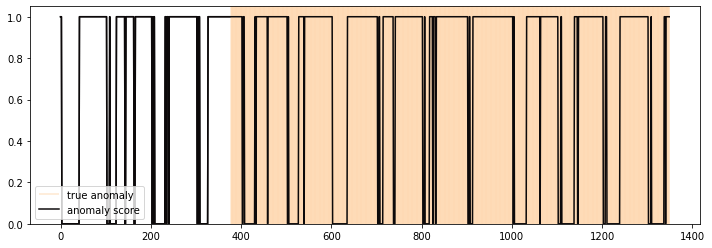

In [50]:
check_graph(y_pred_binary, y_test)
plt.show()

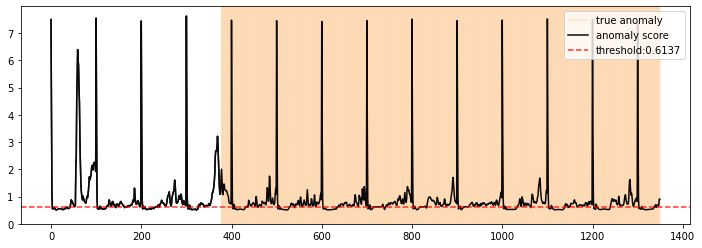

In [51]:
check_graph(y_pred, y_test, threshold=threshold)
plt.show()

In [52]:
bead_counter = []
pred_tf = [True if (i == 1.0) else False for i in y_pred_binary]
for i in range(len(pred_tf)//54):
    bead_counter.append(dict(Counter(pred_tf[i*54: (i+1)*54])))

print(bead_counter)

[{True: 15, False: 39}, {True: 49, False: 5}, {False: 17, True: 37}, {True: 41, False: 13}, {False: 18, True: 36}, {True: 36, False: 18}, {False: 3, True: 51}, {True: 29, False: 25}, {True: 52, False: 2}, {True: 30, False: 24}, {False: 1, True: 53}, {True: 21, False: 33}, {True: 54}, {True: 40, False: 14}, {True: 48, False: 6}, {False: 11, True: 43}, {True: 45, False: 9}, {True: 54}, {True: 32, False: 22}, {False: 8, True: 46}, {True: 25, False: 29}, {False: 7, True: 47}, {True: 20, False: 34}, {True: 54}, {True: 19, False: 35}]


In [53]:
len(bead_counter)

25